In [1]:
import xlrd  # requires xlrd==1.2.0

book = xlrd.open_workbook("data/Table S2 - Positional variability and color of all neurons in males and hermaphrodites v2.xlsx")

data = {'Hermaphrodite Head':{}, 'Hermaphrodite Tail':{},'Male Head':{}, 'Male Tail':{}}

for ws in range(book.nsheets):
    sheet_name = book.sheet_names()[ws]
    
    print('Parsing sheet: %s'%sheet_name)
    sh = book.sheet_by_index(ws)
    
    found=0
    for rx in range(sh.nrows):
            
        neuron = sh.row(rx)[0].value
        if rx>1 and rx<192: #and neuron.startswith('A'):
            ref = '%s %s'%(sheet_name.split()[0],sheet_name.split()[1])
            if 'Positions' in sheet_name:
                data[ref][neuron]={}
                data[ref][neuron]['volume'] = sh.row(rx)[1].value
                data[ref][neuron]['ap_position'] = sh.row(rx)[2].value
                data[ref][neuron]['dv_position'] = sh.row(rx)[3].value
                data[ref][neuron]['lr_position'] = sh.row(rx)[4].value
                #'A-P Distance (μm)	D-V Distance (μm)	L-R Distance (μm)	A-P Variance (μm2)	D-V Variance (μm2)	L-R Variance (μm2)	Effect Size (D
            if 'Colors' in sheet_name:
                if neuron in data[ref]:
                    data[ref][neuron]['mNeptune2.5'] = sh.row(rx)[1].value
                    data[ref][neuron]['CyOFP1'] = sh.row(rx)[2].value
                    data[ref][neuron]['mTagBFP2'] = sh.row(rx)[3].value
        found+=1
    
    print('  Found %i neurons here'%found)
                
import pprint
pp = pprint.PrettyPrinter(indent=4)

#pp.pprint(data)
            

Parsing sheet: Hermaphrodite Head Positions
  Found 192 neurons here
Parsing sheet: Hermaphrodite Head Colors
  Found 192 neurons here
Parsing sheet: Hermaphrodite Tail Positions
  Found 46 neurons here
Parsing sheet: Hermaphrodite Tail Colors
  Found 46 neurons here
Parsing sheet: Male Head Positions
  Found 189 neurons here
Parsing sheet: Male Head Colors
  Found 189 neurons here
Parsing sheet: Male Tail Positions
  Found 111 neurons here
Parsing sheet: Male Tail Colors
  Found 111 neurons here


In [2]:

def translate_pal_color(mneptune,cyofp1, mtag):
    # Very, very, very approximately!
    mx = max([mneptune,cyofp1, mtag])
    rgb = (mneptune/mx,cyofp1/mx, mtag/mx)
    #print('Converted expression (%.3f,%.3f,%.3f) to %s'%(mneptune,cyofp1, mtag,rgb))
    return rgb


for ref in data:
     
    for neuron in data[ref]:
        #print('Handling neuron %s'%neuron)
        if neuron in data[ref]:
            try:
                color = translate_pal_color(data[ref][neuron]['mNeptune2.5'],
                                            data[ref][neuron]['CyOFP1'],
                                            data[ref][neuron]['mTagBFP2'])
            except Exception as e:
                print('*** Exception getting color for %s, %s: %s'%(ref,neuron,e))
                color= (0,0,0)

            data[ref][neuron]['color'] = color
            label = '%s %s'%(neuron, [float('%.2f'%f) for f in color])
            data[ref][neuron]['label'] = label
            #print(label)
        

*** Exception getting color for Male Tail, PVPL: 'mNeptune2.5'
*** Exception getting color for Male Tail, PVPR: 'mNeptune2.5'


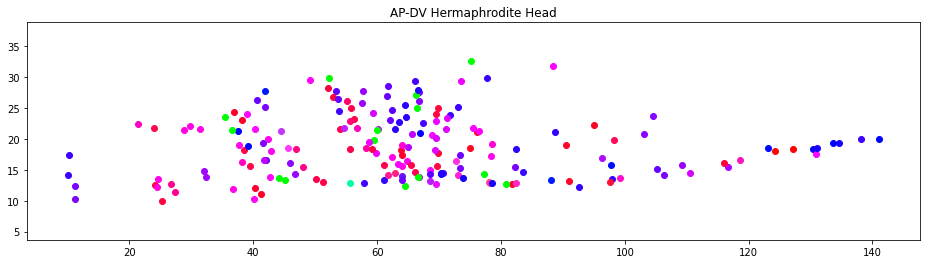

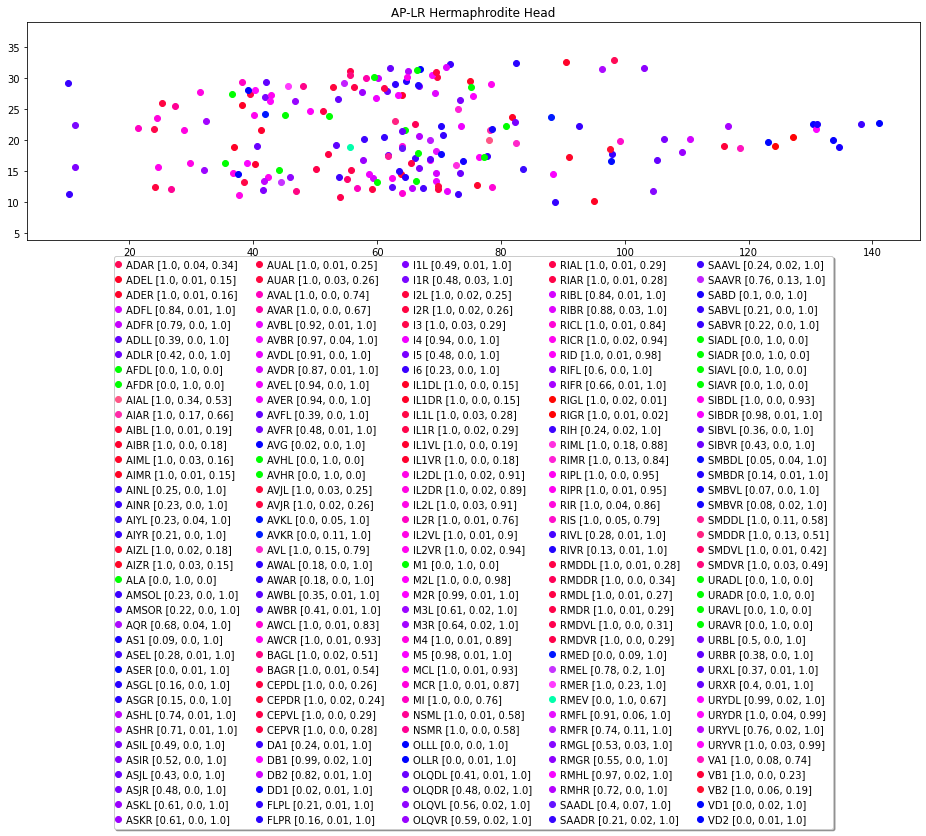

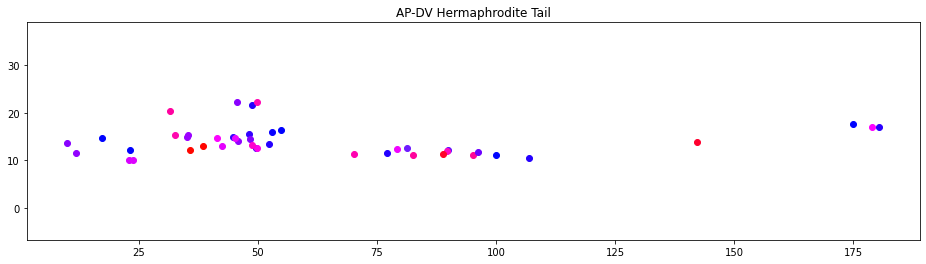

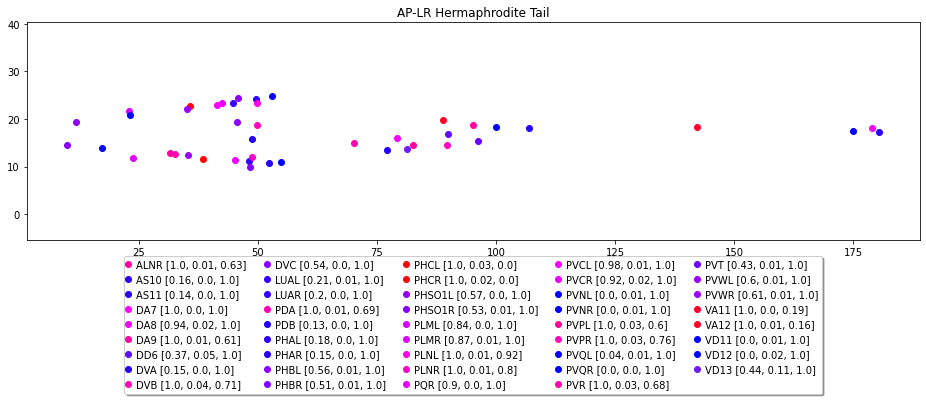

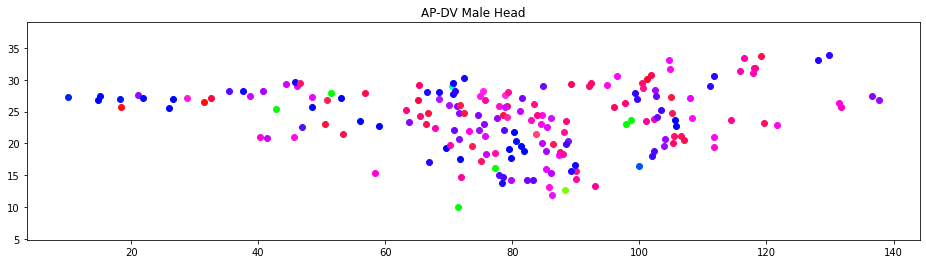

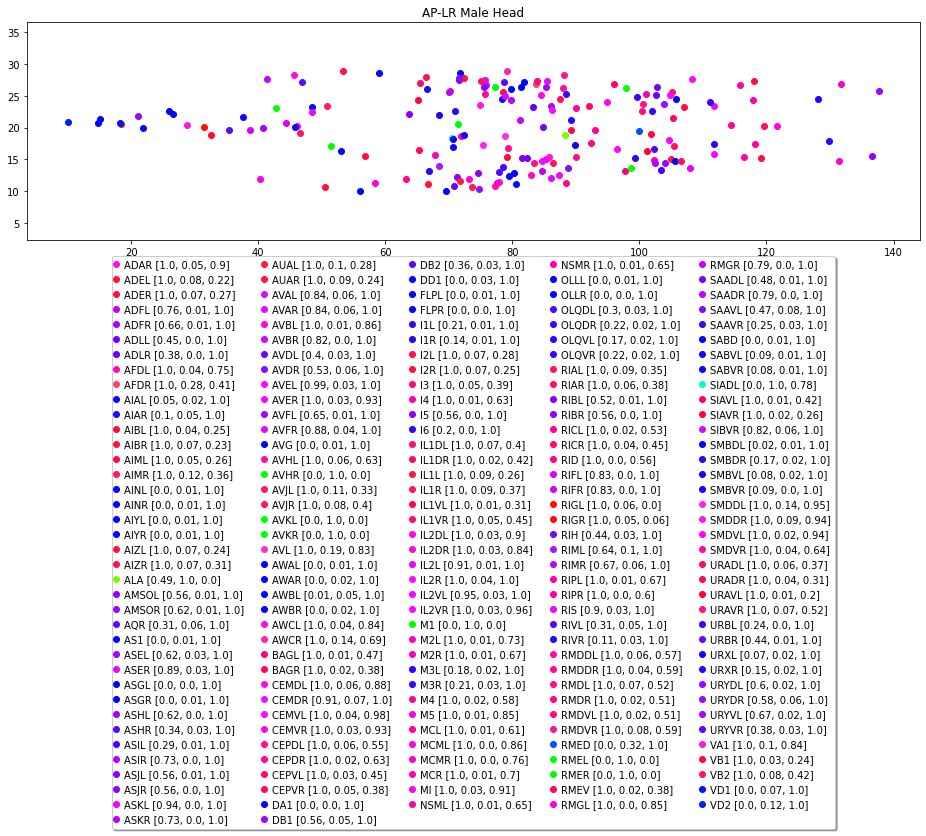

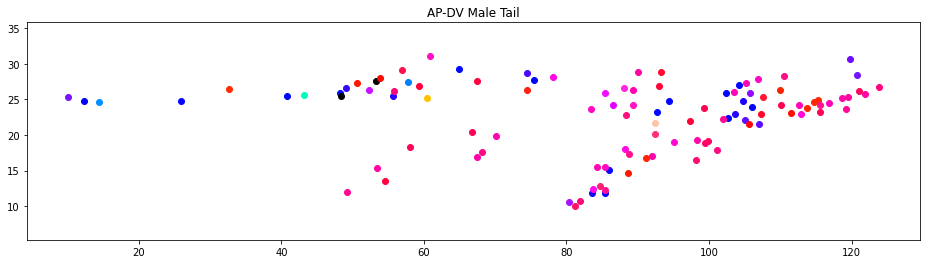

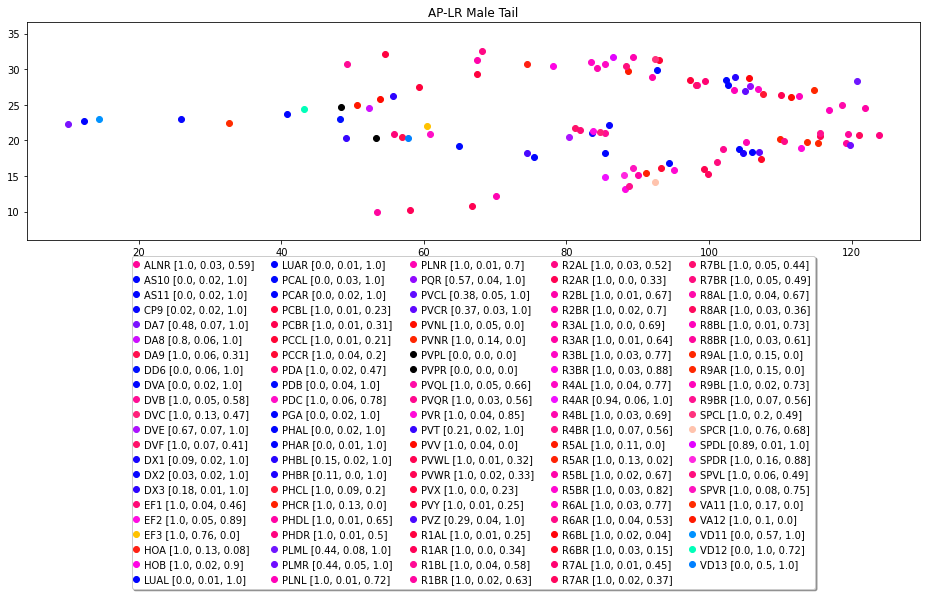

In [3]:

%matplotlib inline  

import matplotlib
import matplotlib.pyplot as plt


for ref in data:
    matplotlib.rcParams['legend.handlelength'] = 0
    plt.rcParams["figure.figsize"] = (16,4)
    
    plt.figure()
    plt.title('AP-DV %s'%ref)
    plt.axis('equal')
    
    for neuron in data[ref]:
        
        label=None
        plt.plot(data[ref][neuron]['ap_position'], 
                 data[ref][neuron]['dv_position'], 
                 marker="o",
                 linestyle=None,
                 color=data[ref][neuron]['color'],
                 label=label)

    plt.figure()
    plt.title('AP-LR %s'%ref)
    plt.axis('equal')
    for neuron in data[ref]:

        plt.plot([data[ref][neuron]['ap_position']], 
                 [data[ref][neuron]['lr_position']], 
                 marker="o",
                 linestyle=None,
                 color=data[ref][neuron]['color'],
                 label=data[ref][neuron]['label'])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)

plt.show()

In [4]:


import neuroml
from pyneuroml import pynml

import neuroml.writers as writers


sets_to_include = ['Hermaphrodite Head','Hermaphrodite Tail','Male Head','Male Tail']

prototype_neuron = 'GenericNeuronCell'
cell = neuroml.FitzHughNagumoCell(id=prototype_neuron, I=0.1)

nml_doc_hm = neuroml.NeuroMLDocument(id="NeuroPAL_Herm_Male")
nml_doc_hm.fitz_hugh_nagumo_cells.append(cell)

net_hm = neuroml.Network(id=nml_doc_hm.id)
nml_doc_hm.networks.append(net_hm)

for ref in data:
    if ref in sets_to_include:
        
        ref_ = ref.replace(' ','_')
        nml_doc = neuroml.NeuroMLDocument(id="NeuroPAL_%s"%ref_)
        nml_doc.fitz_hugh_nagumo_cells.append(cell)

        net = neuroml.Network(id=nml_doc.id)
        nml_doc.networks.append(net)
    
        for neuron in data[ref]:

            # Add in file for individual part
            pop = neuroml.Population(id="%s"%neuron, component=prototype_neuron, type="populationList")
            net.populations.append(pop)
            c = data[ref][neuron]['color']
            pop.properties.append(neuroml.Property(tag="color", value='%f %f %f'%(c[0],c[1],c[2])))
            pop.properties.append(neuroml.Property(tag="radius", value=2))

            inst = neuroml.Instance(id="0")
            pop.instances.append(inst)

            inst.location = neuroml.Location(x=data[ref][neuron]['ap_position'], 
                                     y=data[ref][neuron]['dv_position'], 
                                     z=data[ref][neuron]['lr_position'])
        
            
            # Add in file for all parts
            pop = neuroml.Population(id="%s_%s"%(neuron,ref_), component=prototype_neuron, type="populationList")
            net_hm.populations.append(pop)
            c = data[ref][neuron]['color']
            pop.properties.append(neuroml.Property(tag="color", value='%f %f %f'%(c[0],c[1],c[2])))
            pop.properties.append(neuroml.Property(tag="radius", value=2))

            inst = neuroml.Instance(id="0")
            pop.instances.append(inst)
            
            offset = {'Hermaphrodite_Head':(0,0,0),
                      'Hermaphrodite_Tail':(300,0,0),
                      'Male_Head':(150,40,80),
                      'Male_Tail':(150,40,80)}
            
            transform_x = {'Hermaphrodite_Head':1,
                      'Hermaphrodite_Tail':-1,
                      'Male_Head':-1,
                      'Male_Tail':1}
            
            transform_y = {'Hermaphrodite_Head':1,
                      'Hermaphrodite_Tail':1,
                      'Male_Head':-1,
                      'Male_Tail':-1}

            inst.location = neuroml.Location(
                               x=transform_x[ref_]*data[ref][neuron]['ap_position']+offset[ref_][0], 
                               y=transform_y[ref_]*data[ref][neuron]['dv_position']+offset[ref_][1], 
                               z=data[ref][neuron]['lr_position']+offset[ref_][2])
            
            
            

        ###### Write the NeuroML network file ######   
        nml_file = 'NeuroML2/%s.net.nml'%net.id
        writers.NeuroMLWriter.write(nml_doc, nml_file)
        print("Written network file to: "+nml_file)

        ###### Validate the NeuroML ######    
        from neuroml.utils import validate_neuroml2
        validate_neuroml2(nml_file)
        
        
        ###### Convert NeuroML network to svg ######    
        # pynml.nml2_to_svg(nml_file) # uncomment this line to regenerate, commented out as quite verbose
        
            

###### Write the NeuroML network file with all parts ######   
nml_file_hm = 'NeuroML2/%s.net.nml'%net_hm.id
writers.NeuroMLWriter.write(nml_doc_hm, nml_file_hm)
print("Written network file to: "+nml_file_hm)

###### Validate the NeuroML ######    
from neuroml.utils import validate_neuroml2
validate_neuroml2(nml_file_hm)


###### Convert NeuroML network to svg ######    
#pynml.nml2_to_svg(nml_file_hm) # uncomment this line to regenerate, commented out as quite verbose
        
            

Written network file to: NeuroML2/NeuroPAL_Hermaphrodite_Head.net.nml
Validating NeuroML2/NeuroPAL_Hermaphrodite_Head.net.nml against /Users/padraig/anaconda/envs/py37/lib/python3.7/site-packages/libNeuroML-0.4.0-py3.7.egg/neuroml/nml/NeuroML_v2.3.xsd
It's valid!
Written network file to: NeuroML2/NeuroPAL_Hermaphrodite_Tail.net.nml
Validating NeuroML2/NeuroPAL_Hermaphrodite_Tail.net.nml against /Users/padraig/anaconda/envs/py37/lib/python3.7/site-packages/libNeuroML-0.4.0-py3.7.egg/neuroml/nml/NeuroML_v2.3.xsd
It's valid!
Written network file to: NeuroML2/NeuroPAL_Male_Head.net.nml
Validating NeuroML2/NeuroPAL_Male_Head.net.nml against /Users/padraig/anaconda/envs/py37/lib/python3.7/site-packages/libNeuroML-0.4.0-py3.7.egg/neuroml/nml/NeuroML_v2.3.xsd
It's valid!
Written network file to: NeuroML2/NeuroPAL_Male_Tail.net.nml
Validating NeuroML2/NeuroPAL_Male_Tail.net.nml against /Users/padraig/anaconda/envs/py37/lib/python3.7/site-packages/libNeuroML-0.4.0-py3.7.egg/neuroml/nml/NeuroML_v

# Images generated from NeuroML

### Hermaphrodite Head

![svg from neuroml](NeuroML2/NeuroPAL_Hermaphrodite_Head.net.svg)

### Hermaphrodite Tail

![svg from neuroml](NeuroML2/NeuroPAL_Hermaphrodite_Tail.net.svg)

### Male Head

![svg from neuroml](NeuroML2/NeuroPAL_Male_Head.net.svg)

### Male Tail

![svg from neuroml](NeuroML2/NeuroPAL_Male_Tail.net.svg)

### All 4 parts

![svg from neuroml](NeuroML2/NeuroPAL_Herm_Male.net.svg) 

